In [101]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import matplotlib.pyplot as plt
from skimage.io import imread
import random

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))


In [102]:
#Load the dataset
root_path = '/kaggle/input/airbus-ship-detection'
train_path = '/kaggle/input/airbus-ship-detection/train_v2'
test_path = '/kaggle/input/airbus-ship-detection/test_v2'
csv_path = "/kaggle/input/airbus-ship-detection/train_ship_segmentations_v2.csv"

In [103]:
os.listdir(root_path)

['test_v2',
 'sample_submission_v2.csv',
 'train_ship_segmentations_v2.csv',
 'train_v2']

In [104]:
train_data = pd.read_csv(csv_path)
train_data

ImageId                                      EncodedPixels
0       00003e153.jpg                                                NaN
1       0001124c7.jpg                                                NaN
2       000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...
3       000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...
4       000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
...               ...                                                ...
231718  fffedbb6b.jpg                                                NaN
231719  ffff2aa57.jpg                                                NaN
231720  ffff6e525.jpg                                                NaN
231721  ffffc50b4.jpg                                                NaN
231722  ffffe97f3.jpg                                                NaN

[231723 rows x 2 columns]

In [105]:
print(train_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231723 entries, 0 to 231722
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   ImageId        231723 non-null  object
 1   EncodedPixels  81723 non-null   object
dtypes: object(2)
memory usage: 3.5+ MB
None


In [106]:
# Check the distribution of missing data
print(train_data.isnull().sum())

ImageId               0
EncodedPixels    150000
dtype: int64


has_ship
False    150000
True      42556
Name: count, dtype: int64


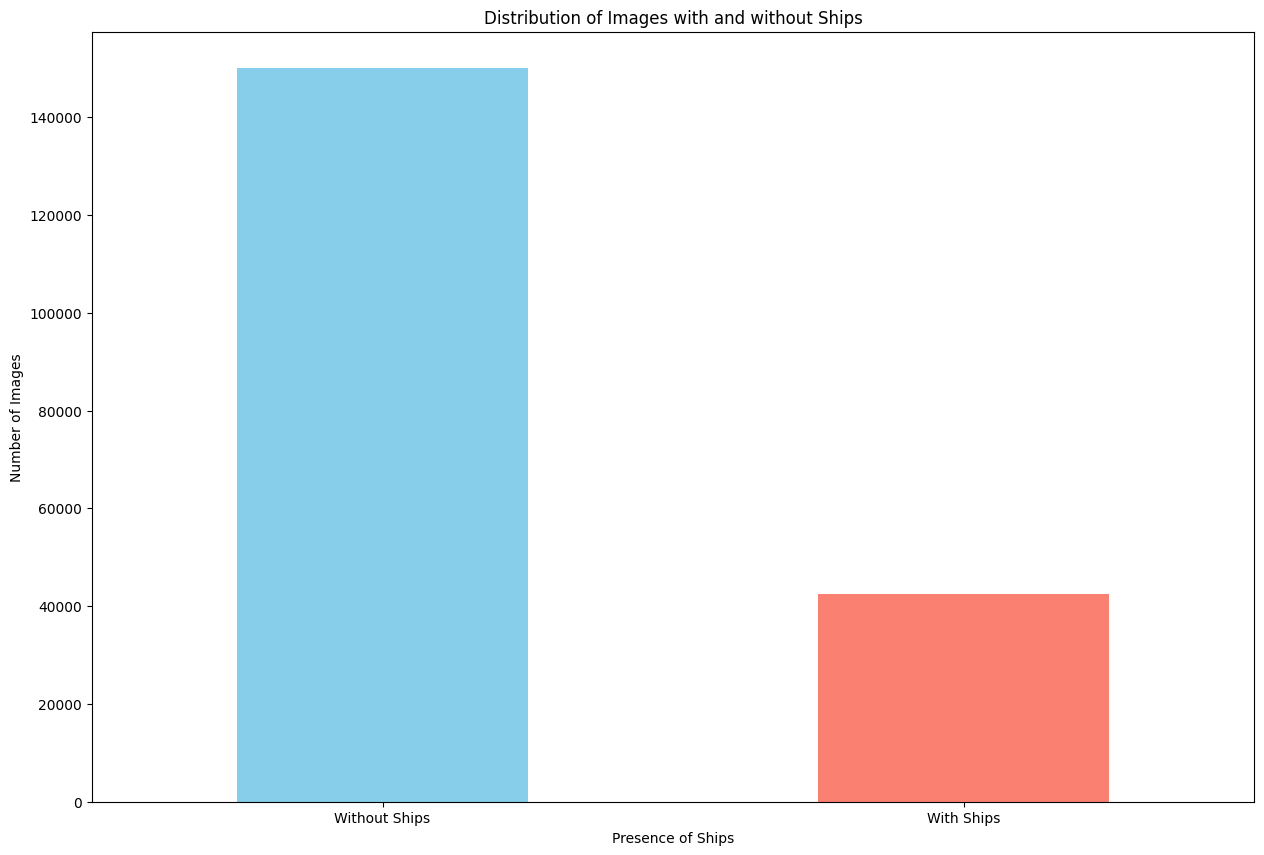

In [107]:
#Add column to mark the presence of ships
train_data['has_ship'] = train_data['EncodedPixels'].notnull()

#Group by ImageId and check the presence of ships
grouped_data = train_data.groupby('ImageId')['has_ship'].any().reset_index()

#Count of images 
ship_count = grouped_data['has_ship'].value_counts()
print(ship_count)

plt.figure(figsize=(15, 10))
ship_count.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribution of Images with and without Ships')
plt.xlabel('Presence of Ships')
plt.ylabel('Number of Images')
plt.xticks(ticks=[0, 1], labels=['Without Ships', 'With Ships'], rotation=0)
plt.show()

In [108]:
#Group by ImageId and count the number of ships on each image
ship_counts_per_image = train_data.groupby('ImageId')['EncodedPixels'].count().reset_index()
ship_counts_per_image.columns = ['ImageId', 'ship_count']

#Distribution of the number of ships on images
ship_distribution = ship_counts_per_image['ship_count'].value_counts()
print(ship_distribution)

ship_count
0     150000
1      27104
2       7674
3       2954
4       1622
5        925
6        657
7        406
8        318
9        243
10       168
11       144
12       124
14        76
13        75
15        66
Name: count, dtype: int64


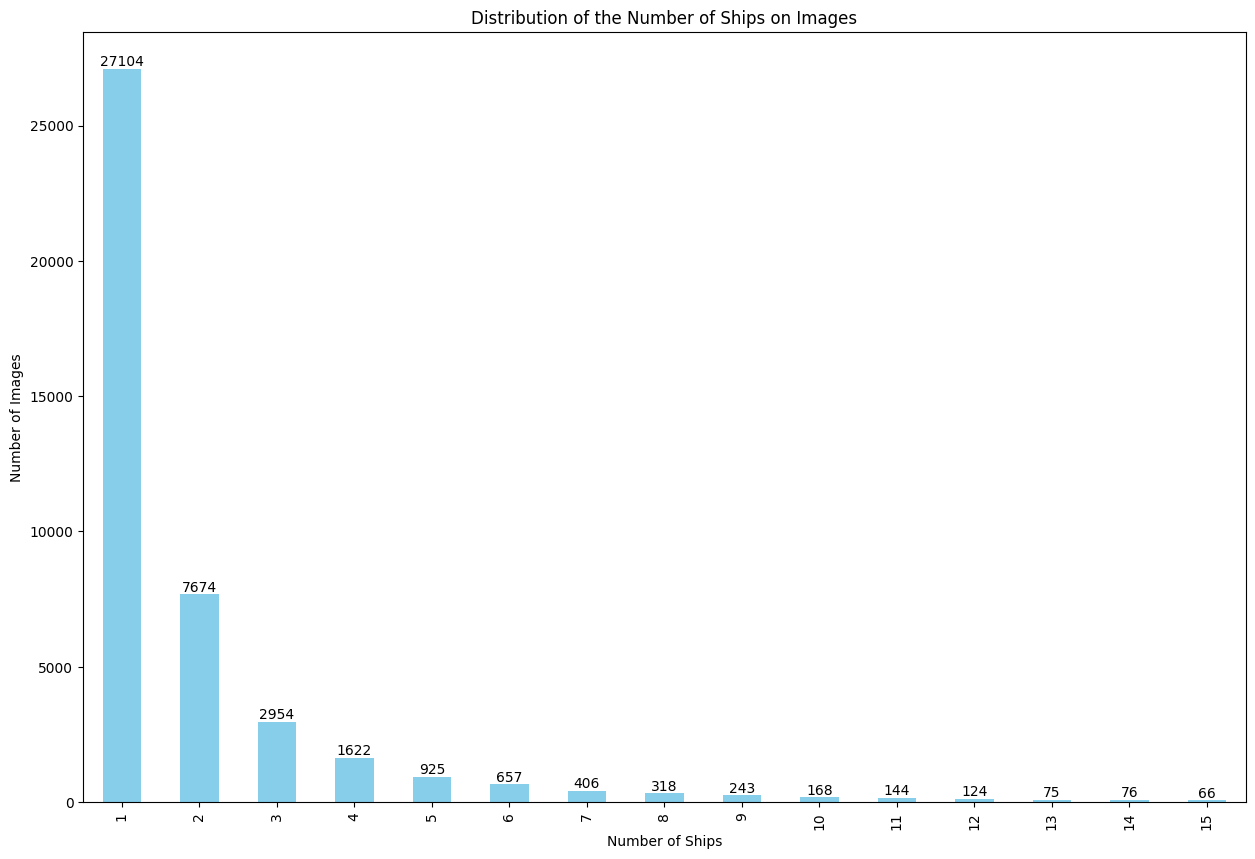

In [109]:
# Filter images with at least one ship
ship_counts_per_image = ship_counts_per_image[ship_counts_per_image['ship_count'] > 0]

#Distribution of the number of ships on images
ship_distribution = ship_counts_per_image['ship_count'].value_counts().sort_index()

plt.figure(figsize=(15, 10))
ax = ship_distribution.plot(kind='bar', color='skyblue')
plt.title('Distribution of the Number of Ships on Images')
plt.xlabel('Number of Ships')
plt.ylabel('Number of Images')

for i in ax.containers:
    ax.bar_label(i)

plt.show()

# Example of an Input Image and сorresponding Mask

In [110]:
train_files = os.listdir(train_path)
print(f'Number of images in train set: {len(train_files)}')
test_files = os.listdir(test_path)
print(f'Number of images in test set: {len(test_files)}')


Number of images in train set: 192556
Number of images in test set: 15606


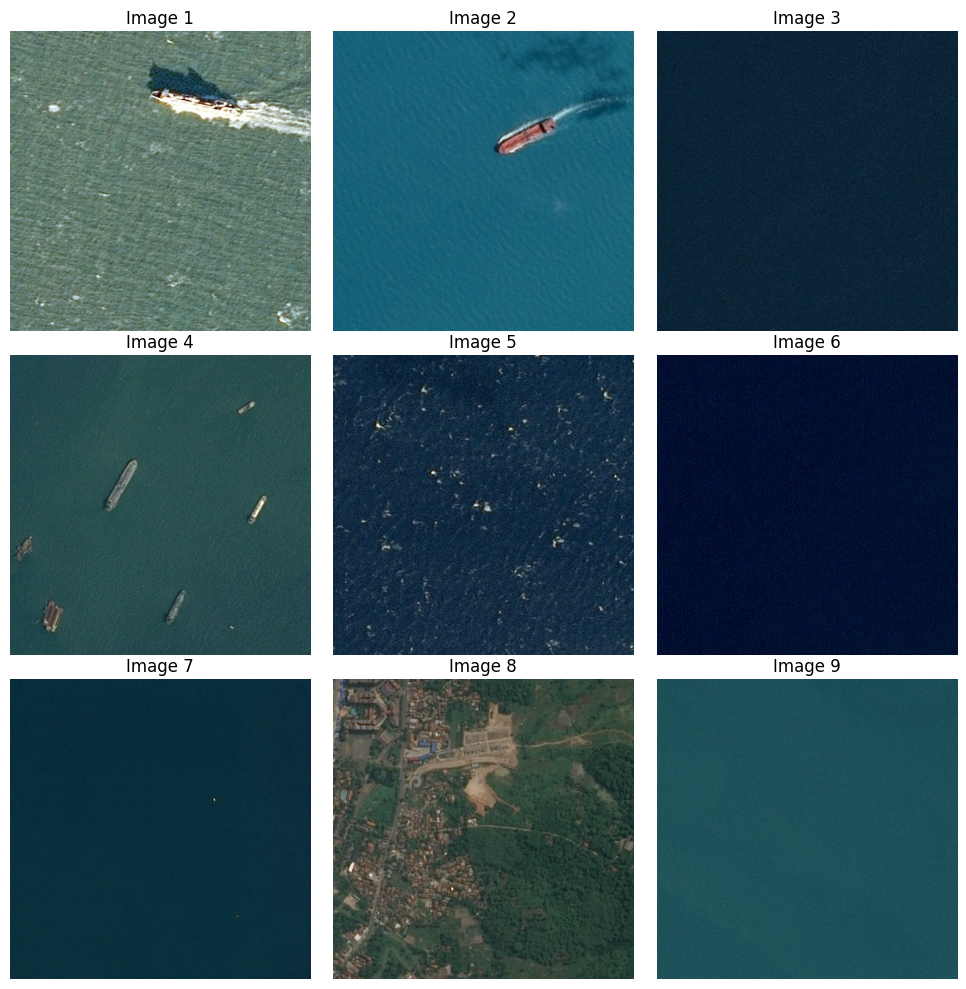

In [111]:
fig, axarr = plt.subplots(3, 3, figsize=(10, 10))

for i, ax in enumerate(axarr.flat):
    
    img = imread(os.path.join(train_path, train_files[i + 200]))
    ax.axis('off')
    ax.imshow(img)
    ax.set_title(f'Image {i+1}')

plt.tight_layout(h_pad=0.1, w_pad=0.1)
plt.show()

In [112]:
# Filter images with ships
data_with_ships = train_data[train_data['EncodedPixels'].notnull()]

# Decoding masks in Run-Length Encoding format
def rle_decode(mask_rle, shape=(768, 768)):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0::2], s[1::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape, order='F')

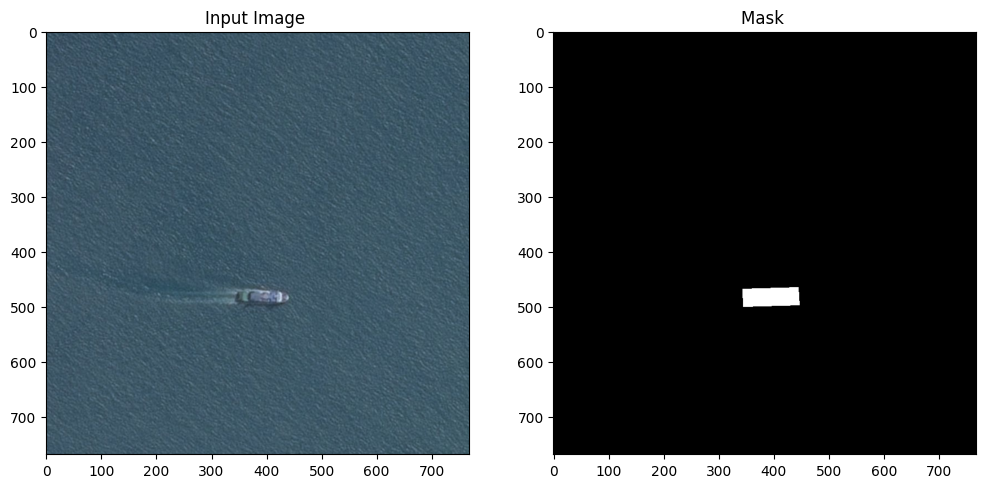

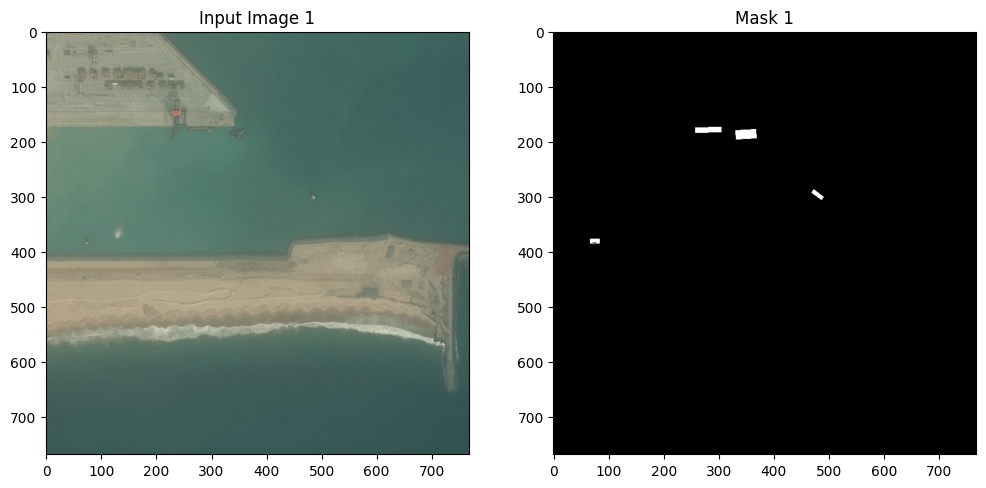

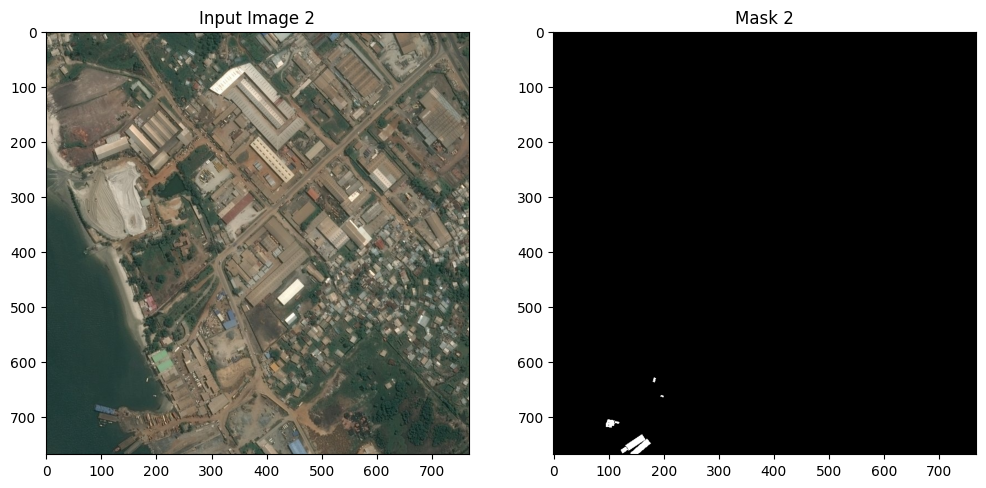

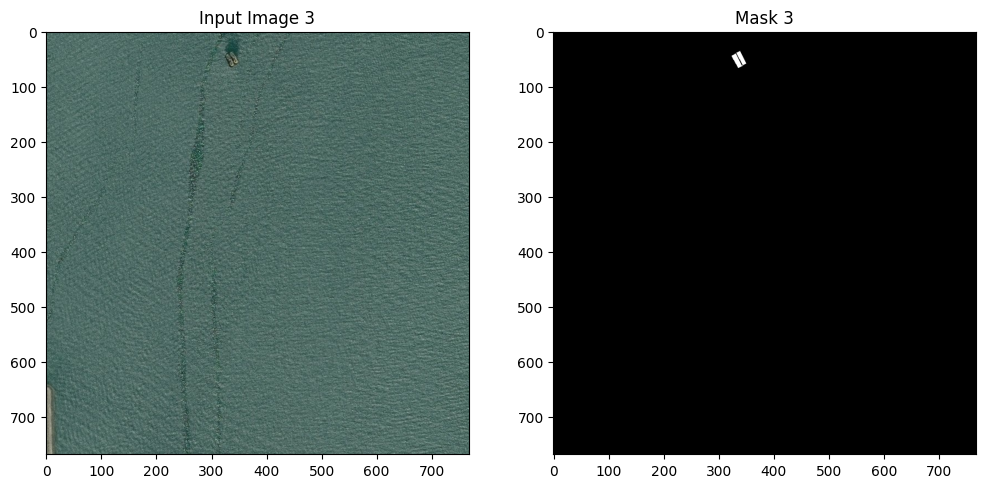

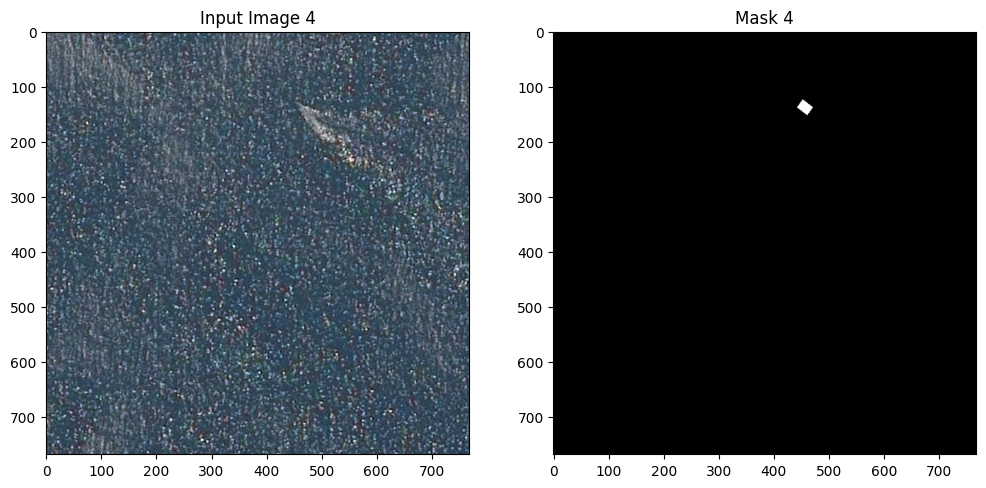

In [115]:
# Visualize the image and mask
def visualize_image_and_mask(image_id, train_path, title_suffix=''):
    image_path = os.path.join(train_path, image_id)
    image = imread(image_path)
    masks = data_with_ships[data_with_ships['ImageId'] == image_id]['EncodedPixels'].tolist()
    mask = np.zeros((768, 768), dtype=np.uint8)
    
    for mask_rle in masks:
        mask += rle_decode(mask_rle)
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    
    ax[0].imshow(image)
    ax[0].set_title(f'Input Image {title_suffix}')
    
    ax[1].imshow(mask, cmap='gray')
    ax[1].set_title(f'Mask {title_suffix}')
    
    plt.show()

    
# Visualization for one example
example_image_id = data_with_ships['ImageId'].values[0]
visualize_image_and_mask(example_image_id, train_path)

# Visualize multiple images with their masks
example_image_ids = data_with_ships['ImageId'].unique()[1:5]
for i, image_id in enumerate(example_image_ids):
    visualize_image_and_mask(image_id, train_path, title_suffix=f'{i+1}')



# Heatmap of Ship Positions

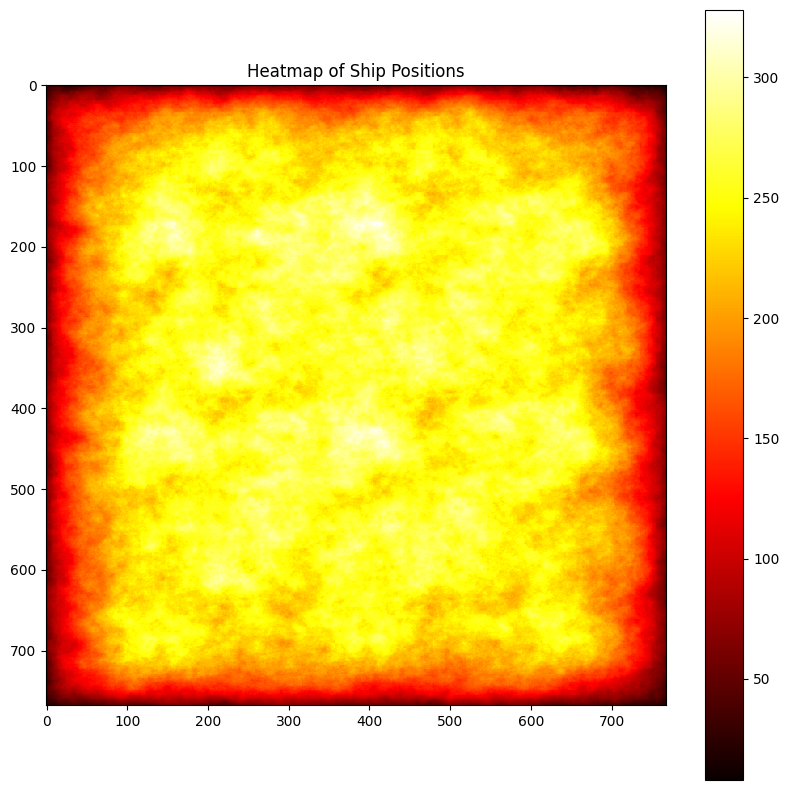

In [116]:
heatmap = np.zeros((768, 768))

for mask_rle in data_with_ships['EncodedPixels']:
    heatmap += rle_decode(mask_rle)

plt.figure(figsize=(10, 10))
plt.imshow(heatmap, cmap='hot', interpolation='nearest')
plt.title('Heatmap of Ship Positions')
plt.colorbar()
plt.show()

# Average, Minimum, and Maximum Ship Area

In [117]:
#Adding 'ship_area' column to calculate the ship area
def calculate_ship_area(mask_rle):
    mask = rle_decode(mask_rle)
    return np.sum(mask)

data_with_ships['ship_area'] = data_with_ships['EncodedPixels'].apply(calculate_ship_area)

# Calculating the average, minimum, and maximum ship areas
average_ship_area = data_with_ships['ship_area'].mean()
min_ship_area = data_with_ships['ship_area'].min()
max_ship_area = data_with_ships['ship_area'].max()

print(f'Average ship area: {average_ship_area:.2f} pixels')
print(f'Minimum ship area: {min_ship_area} pixels')
print(f'Maximum ship area: {max_ship_area} pixels')

Average ship area: 1567.40 pixels
Minimum ship area: 2 pixels
Maximum ship area: 25904 pixels


/tmp/ipykernel_33/292399706.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_with_ships['ship_area'] = data_with_ships['EncodedPixels'].apply(calculate_ship_area)


# Percentage of the Image Area Occupied by Ships

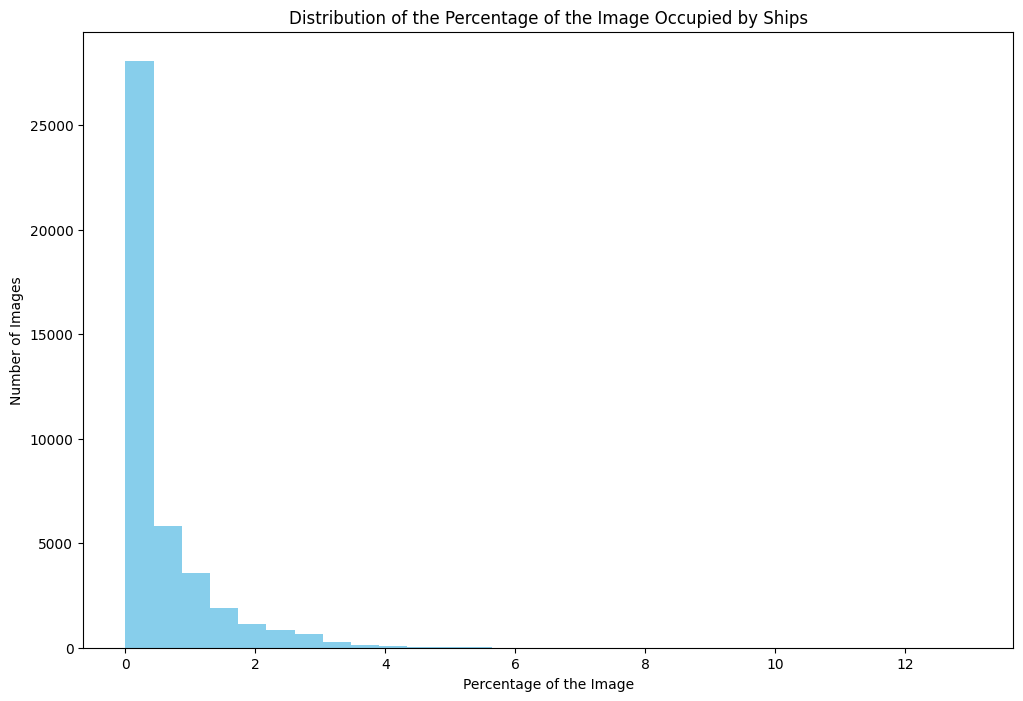

In [118]:
#Calculate the percentage of the image occupied by ships
def calculate_ship_percentage(rle_list, image_shape=(768, 768)):
    total_pixels = image_shape[0] * image_shape[1]
    ship_pixels = sum(np.sum(rle_decode(rle)) for rle in rle_list)
    return (ship_pixels / total_pixels) * 100

# Group masks by ImageId
grouped_data = data_with_ships.groupby('ImageId')['EncodedPixels'].apply(list).reset_index()

# Add a column with the percentage of the image occupied by ships
grouped_data['ship_percentage'] = grouped_data['EncodedPixels'].apply(calculate_ship_percentage)

plt.figure(figsize=(12, 8))
plt.hist(grouped_data['ship_percentage'], bins=30, color='skyblue')
plt.title('Distribution of the Percentage of the Image Occupied by Ships')
plt.xlabel('Percentage of the Image')
plt.ylabel('Number of Images')
plt.show()

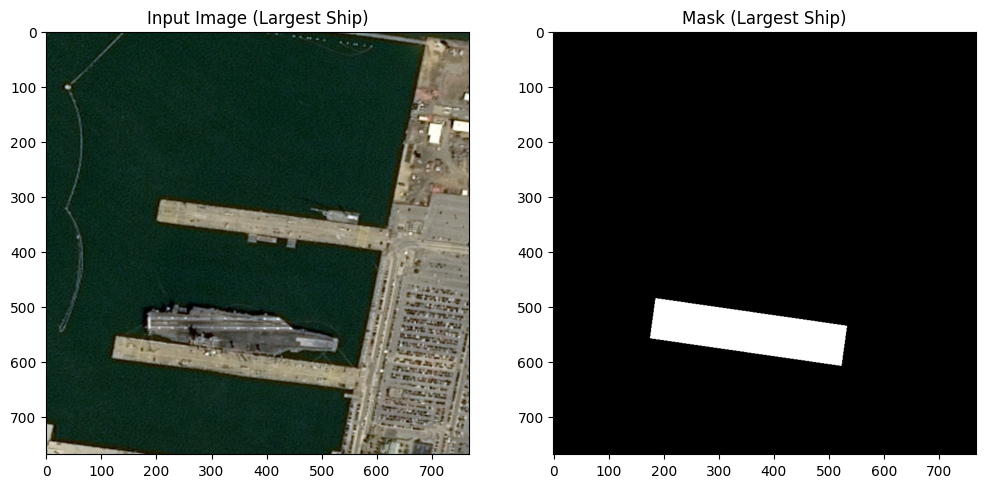

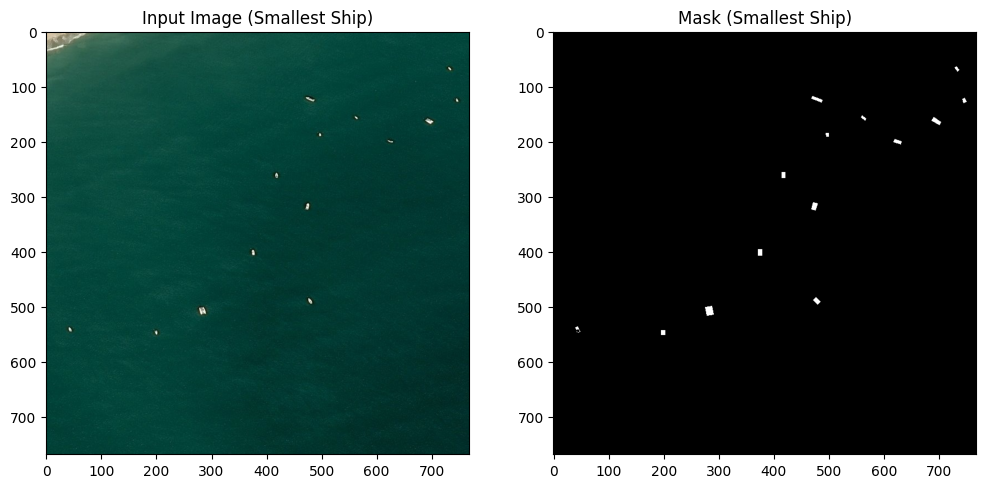

In [120]:
# Visualization for the largest ship
max_ship = data_with_ships[data_with_ships['ship_area'] == max_ship_area].iloc[0]
visualize_image_and_mask(max_ship['ImageId'], train_path, title_suffix='(Largest Ship)')

# Visualization for the smallest ship
min_ship = data_with_ships[data_with_ships['ship_area'] == min_ship_area].iloc[0]
visualize_image_and_mask(min_ship['ImageId'], train_path, title_suffix='(Smallest Ship)')


# Conclusions
As we explored before, there are 192 556 unique images in train dataset, with 42 556 images with ships and 150 000 images without ships. Due to significant inbalance in training data, it is necessary to balance the data later.
There is also noticable inbalance in the number of ships per image:

1 ship: 27,104 images - 63.69%
2 ships: 7,674 images - 18.03%
3 ships: 2,954 images - 6.94%
4 ships: 1,622 images - 3.81%
5 ships: 925 images - 2.17%
6 ships: 657 images - 1.54%
7 ships: 406 images - 0.95%
8 ships: 318 images - 0.75%
9 ships: 243 images - 0.57%
10 ships: 168 images - 0.39%
11 ships: 144 images - 0.34%
12 ships: 124 images - 0.29%
13 ships: 75 images - 0.18%
14 ships: 76 images - 0.18%
15 ships: 66 images - 0.16%

When constructed a heatmap of ship positions around all images,we can notice that ships usually ocuppy the area in the center of images and rarely are at the corners. It might be worth to apply data augmentation to address this.

Additionally, by calculating the area occupied by ships in the images, it is observed that ships occupy on average 0.24% of the image (1567.4 pixels), and in largest(rare case) - 4% of the image (25904 pixels). Worth mentioning that mentioned area is the area of the masks, though ships themselves ocuppy slightly smaller areas due to different shapes.

As it mentioned in the description of the dataset, there were a small percentage of images in both the Train and Test set that had slight overlap of object segments when ships were directly next to each other. This makes it difficult for a simple model to distinguish between them, and it may be necessary to apply techniques to address this issue.